# Developing ngmix-free metacalibration with cookie-cutter

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table
from astropy.io import fits
import galsim
import fitsio
import time
import superbit_lensing.oba.metacal as mcal
from superbit_lensing import cookiecutter
from scipy.optimize import minimize

## Test mcal functions on COSMOS

In [3]:
boxsize=51
pixel_scale=.1

In [4]:
import superbit_lensing.oba.measure as meas
meas.generate_gal(7,565)

galsim.Transformation(galsim.Sersic(n=0.30000000000000004, scale_radius=0.6959368904137445, trunc=0.0, flux=4.535268860380321, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.5052460000759371, 0.211430305895889], [0.211430305895889, 0.6940412226297401]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=271.7192057897698, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)

Text(0.5, 1.0, 'Pixelisation')

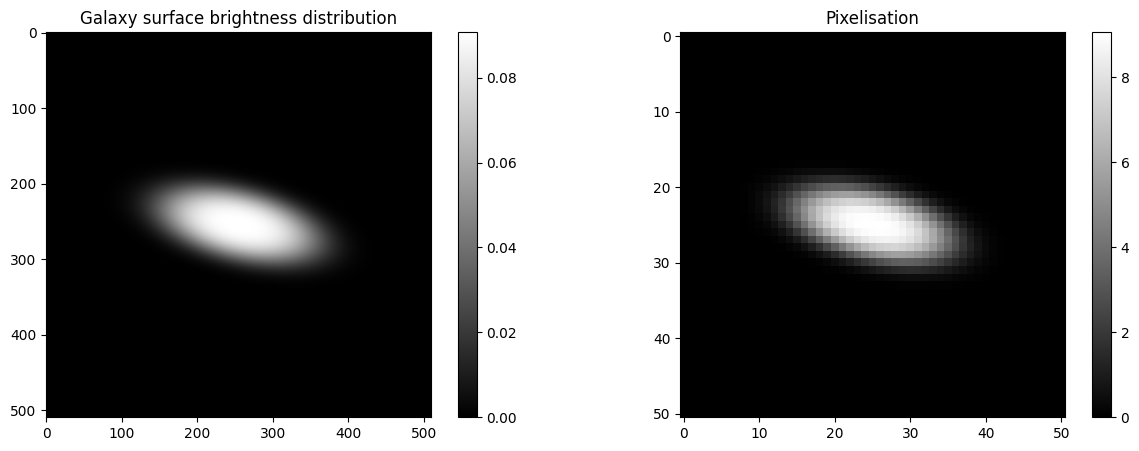

In [5]:
gal = meas.generate_gal(7,565)
figure(figsize(15,5))
subplot(121)
imshow(gal.drawImage(nx=510,ny=510,scale=0.01).array,cmap="gist_gray");colorbar()
title("Galaxy surface brightness distribution")
subplot(122)
imshow(gal.drawImage(nx=51,ny=51,scale=0.1).array,cmap="gist_gray");colorbar()
title("Pixelisation")

get psf

In [6]:
psf = fitsio.FITS("../superbit_lensing/oba/sims/sed_true_26892756.os.fits")

In [7]:
true_psf1 = meas.galsimator(psf[1].read(),pixel_scale=.1/5)
true_psf2 = meas.galsimator(psf[1].read(),pixel_scale=.1005/5) #.5pc defocused?

Observed psfs have a bit of noise

Text(0.5, 1.0, 'example of observed psf')

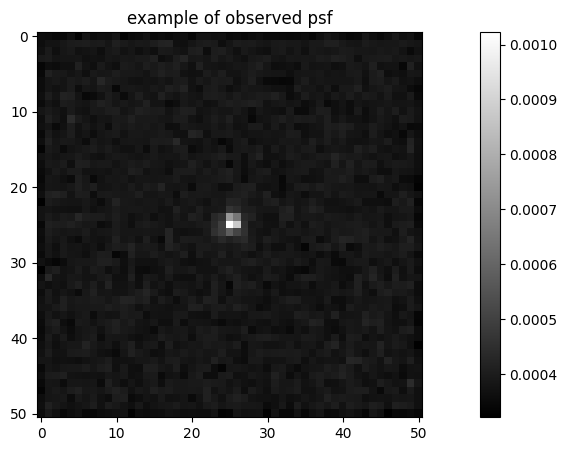

In [8]:
psf_nois = meas.make_noise(boxsize=51,sky_level=0.1,noise_level=0.005)
imshow((true_psf1 + meas.galsimator(psf_nois,pixel_scale=.1)).withFlux(1).drawImage(nx=51,ny=51,scale=.1).array,cmap="gist_gray");colorbar()
title("example of observed psf")

In [9]:
obs_psf1 = (true_psf1 + meas.galsimator(psf_nois,pixel_scale=.1)).withFlux(1)
obs_psf2 = (true_psf2 + meas.galsimator(psf_nois.T,pixel_scale=.1)).withFlux(1)

Text(0.5, 1.0, 'Exposure 2')

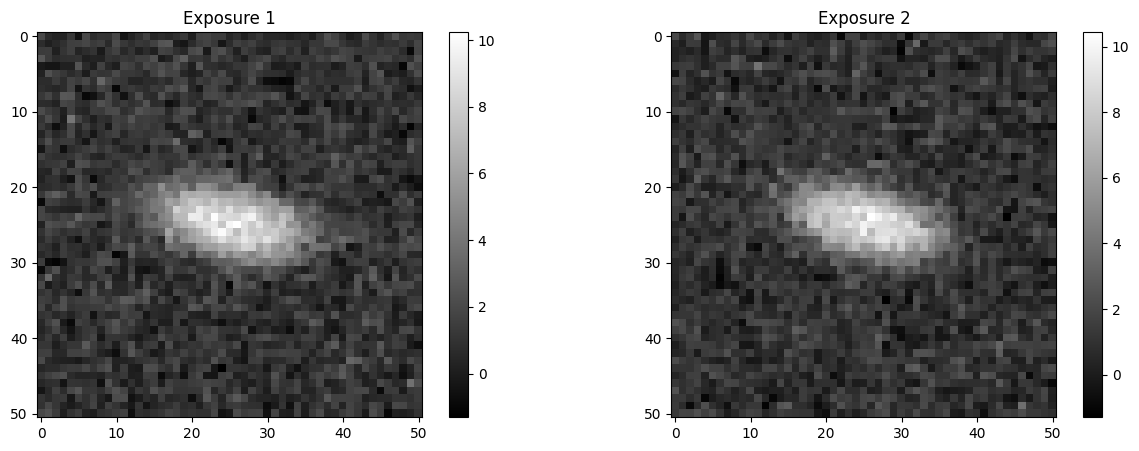

In [10]:
nois = meas.make_noise(boxsize=51,sky_level=1.,noise_level=1.)
psfs = array([true_psf1,true_psf2])
obs1 = galsim.Convolve([gal,true_psf1]) + meas.galsimator(nois,pixel_scale=.1)
obs2 = galsim.Convolve([gal,true_psf2]) + meas.galsimator(nois.T,pixel_scale=.1)
obs_ims = array([obs1.drawImage(nx=51,ny=51,scale=.1).array,obs2.drawImage(nx=51,ny=51,scale=.1).array])

figure(figsize=(15,5))
subplot(121)
imshow(obs_ims[0],cmap="gist_gray");colorbar()
title("Exposure 1")
subplot(122)
imshow(obs_ims[1],cmap="gist_gray");colorbar()
title("Exposure 2")

create a loss function for optimization

In [11]:
model = meas.gaussian_model
loss=meas.create_loss(model=model,images=obs_ims,sky_levels=[1.,1.],psf_objs=psfs,boxsize=51,pixel_scale=.1)

In [12]:
gal_flu = sum(obs_ims[0]) - 1.*boxsize**2

In [13]:
result=minimize(loss,x0=array([gal_flu,1.,0.,0.]),bounds=[(gal_flu*0.5,gal_flu*1.5),(.1,10.),(-.7,.7),(-.7,.7)],method='Nelder-Mead')
print(*result.x)

1310.9037089115996 0.5047549903324013 0.38016804824308037 0.1849773264160196


In [14]:
fitted=model(*result.x,[1.,1.],psfs,51,.1)

Text(0.5, 1.0, 'Residuals 2')

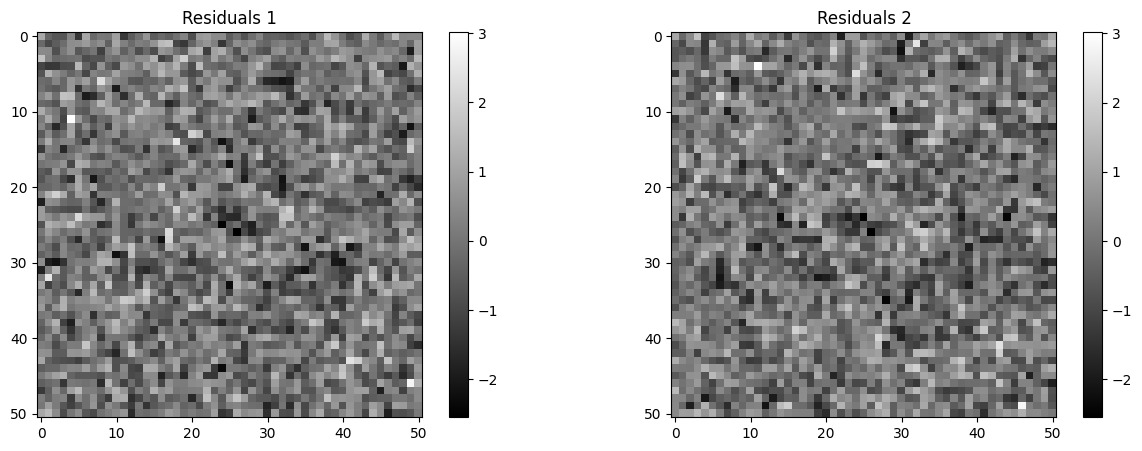

In [15]:
figure(figsize=(15,5))
subplot(121)
imshow(obs_ims[0]-fitted[0],cmap="gist_gray");colorbar()
title("Residuals 1")
subplot(122)
imshow(obs_ims[1]-fitted[1],cmap="gist_gray");colorbar()
title("Residuals 2")

## Metacalibration

In [16]:
def get_ellipticities(obss,psfs,sky_levels):
  gal_flu = (np.sum(obs_ims,axis=(1,2)) - sky_levels*boxsize**2).mean()
  loss=meas.create_loss(model=model,images=obss,sky_levels=[1.,1.],psf_objs=psfs,boxsize=51,pixel_scale=.1)
  result=minimize(loss,x0=array([gal_flu,1.,0.,0.]),bounds=[(gal_flu*0.5,gal_flu*1.5),(.1,10.),(-.7,.7),(-.7,.7)],method='Nelder-Mead')
  return result.x[-2:]

In [17]:
reconv_psf = galsim.Gaussian(fwhm=.7)

In [18]:
galsim.Deconvolve(psfs[0])

galsim.Deconvolution(galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-400, xmax=399, ymin=-400, ymax=399), array=
array([[1.94383067e-09, 1.87321445e-09, 1.81295795e-09, ...,
        2.08166166e-09, 2.06114167e-09, 2.01191686e-09],
       [1.93804313e-09, 1.81095894e-09, 1.71754607e-09, ...,
        2.24290636e-09, 2.18337722e-09, 2.07391066e-09],
       [1.94494628e-09, 1.77862008e-09, 1.66282360e-09, ...,
        2.37580513e-09, 2.28414518e-09, 2.12941671e-09],
       ...,
       [2.04931254e-09, 2.15162587e-09, 2.20082464e-09, ...,
        1.71683728e-09, 1.79906618e-09, 1.91893698e-09],
       [2.00384957e-09, 2.05892337e-09, 2.07608818e-09, ...,
        1.79322605e-09, 1.84945321e-09, 1.92578469e-09],
       [1.96640354e-09, 1.96079248e-09, 1.93978622e-09, ...,
        1.92066876e-09, 1.94108102e-09, 1.95808072e-09]]), wcs=galsim.PixelScale(0.02)), galsim.Lanczos(14, True, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-

In [19]:
obsdict=mcal.get_all_metacal(gals=[meas.galsimator(obs_ims[0]),meas.galsimator(obs_ims[1])] ,
                     psfs=psfs,
                     reconv_psfs=[reconv_psf,reconv_psf],fixnoise=False)

In [27]:
def measure_ellipticities(obsdict,method):
    resdict = {}
    for key in obsdict.keys():
        resdict += {key: method(obsdict[key])}
    return resdict

In [30]:
def method(obstype,sky_levels=array([1.,1.])):
  obss=obstype['obs']
  psfs=obstype['psf']
  result=get_ellipticities(obss,psfs,sky_levels)
  return result
  

In [31]:
measure_ellipticities(obsdict=obsdict,method=method)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

## Make bridge between cookiecutter and mcal

lets take a look into cookiecutter images

In [ ]:
cookie=cookiecutter.CookieCutter(cookiecutter_file="euclid/euclid_test/Abell2813/vis/out/Abell2813_vis_cutouts.fits")
cookie.initialize()
cctable=Table.read("euclid/euclid_test/Abell2813/vis/out/Abell2813_vis_cutouts.fits")

In [ ]:
figure(figsize=(20,20))
pos = 0
while pos <  16:
  pos+=1
  choice = pos#np.random.randint(0,len(cctable))
  obj_id = cctable[choice]['object_id']
  ext_no = cctable[choice]['img_ext']
  cut = cookie.get_cutout(obj_id,extnumber=ext_no)
  subplot(4,4,pos)
  imshow(cut,origin='lower',cmap='gist_gray');colorbar()
  title(f"id={obj_id}, ext={ext_no}")
  
savefig(f"cookies_{time.time()}.png")

## Test mcal functions on cookiecutter results

## Get some results